In [1]:
username = "Alex"
pathtorepo = "C:\\Users\\" *username *  "\\Desktop\\"
using Pkg
Pkg.activate(pathtorepo * "dynamical-systems\\env\\integrate\\")

  Activating project at `C:\Users\Alex\Desktop\dynamical-systems\env\integrate`


In [2]:
using DynamicalSystems, DifferentialEquations

using Statistics
using StaticArrays
using CairoMakie
using JLD

In [3]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end
Hs(x, k) = Statistics.mean(x) + k * Statistics.std(x)

Hs (generic function with 1 method)

In [4]:
function peaks(x)
    peaks_ = Float64[]
    len_ = length(x)
    for i in range(2, len_ - 1, step = 1)
        if x[i-1] < x[i] > x[i+1]
            push!(peaks_, x[i])
        end
    end
    return peaks_
end

peaks (generic function with 1 method)

In [5]:
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,500000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,500000), pdf
end

CALCPDF (generic function with 1 method)

In [6]:
# tspan = (0., 500000.) was before 30.05.2023
tspan = (0., 500000.)
a = 1.
b = 3.
c = 1.
d = 5.
xr = -1.6
r = 0.01
s = 5.
I = 4.
xv = 2.

k1= -0.17
k2 = k1

-0.17

## border for EE in hyperchaos

In [7]:
cd("C:\\Users\\Alex\\YandexDisk\\Science\\HR\\1d maps\\1d map LSE k1=k2=-0.17")
matrix_condition = load("condition_matrix_k1k2_0.17.jld")["data"];
spectrum = load("spectrum_matrix_k1k2_0.17.jld")["data"];


k_space = range(0.0, 1.0, step = 0.0002)
length(k_space), length(spectrum[1, :])

(5001, 5001)

In [8]:
index = 775
k_space[index]

0.1548

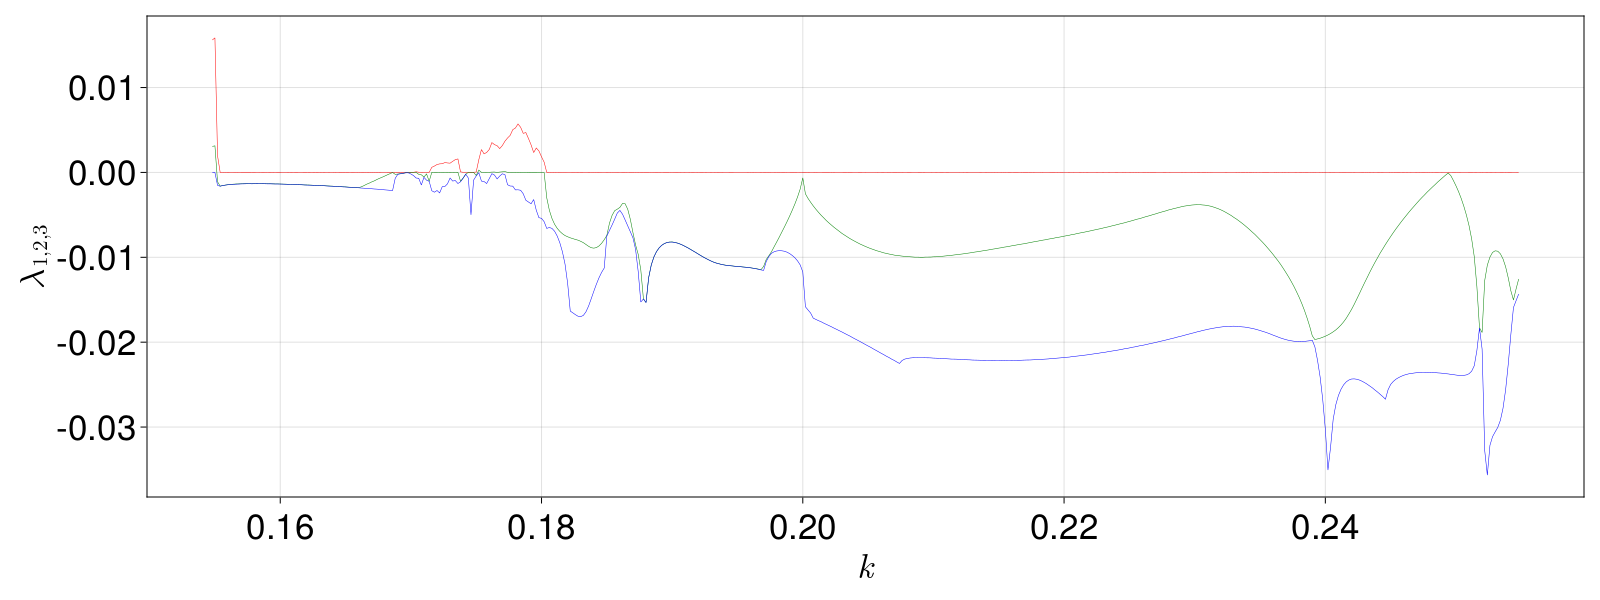

In [9]:
f = Figure(resolution = (1600, 600), fontsize = 35)

ax = Axis(f[1, 1], xlabel = L"k", ylabel = L"\lambda_{1, 2, 3}")

ts = index
tf = index + 500

lines!(ax, k_space[ts:tf], spectrum[1, ts:tf], color = "red", linewidth = 0.5)
lines!(ax, k_space[ts:tf], spectrum[2, ts:tf], color = "green", linewidth = 0.5)
lines!(ax, k_space[ts:tf], spectrum[3, ts:tf], color = "blue", linewidth = 0.5)

f

In [10]:
matrix_condition[:, index]

6-element Vector{Float64}:
 -1.3708880285256102
 -8.022011143224757
  4.3093369397057115
 -0.7483763647564559
 -1.8529391589460256
  4.142716799658893

In [11]:
spectrum[:, index]

6-element Vector{Float64}:
   0.015600802481299884
   0.003065302731414318
  -1.0880680523475515e-5
  -0.007165381408654947
  -5.791063602178957
 -11.880175305217701

In [12]:
condition_chaos = SA[    -1.3708880285256102,
 -8.022011143224757,
  4.3093369397057115,
 -0.7483763647564559,
 -1.8529391589460256,
  4.142716799658893]

6-element SVector{6, Float64} with indices SOneTo(6):
 -1.3708880285256102
 -8.022011143224757
  4.3093369397057115
 -0.7483763647564559
 -1.8529391589460256
  4.142716799658893

In [13]:
k = k_space[index]
p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]

12-element SVector{12, Float64} with indices SOneTo(12):
  1.0
  3.0
  1.0
  5.0
  5.0
 -1.6
  0.01
  4.0
  2.0
 -0.17
 -0.17
  0.1548

In [14]:
prob = ODEProblem(HR, condition_chaos, tspan, p)

ODEProblem with uType SVector{6, Float64} and tType Float64. In-place: false
timespan: (0.0, 500000.0)
u0: 6-element SVector{6, Float64} with indices SOneTo(6):
 -1.3708880285256102
 -8.022011143224757
  4.3093369397057115
 -0.7483763647564559
 -1.8529391589460256
  4.142716799658893

In [15]:
sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000);

In [16]:
xsum = sol[1, :] + sol[4, :];
println("before: ", length(xsum))

xsum = xsum[floor(Int, length(xsum) / 4):end ]
println("after: ", length(xsum))

before: 6922111
after: 5191585


In [17]:
Hs1 = Hs(xsum, 6)

2.863621856800851

In [18]:
CairoMakie.activate!()

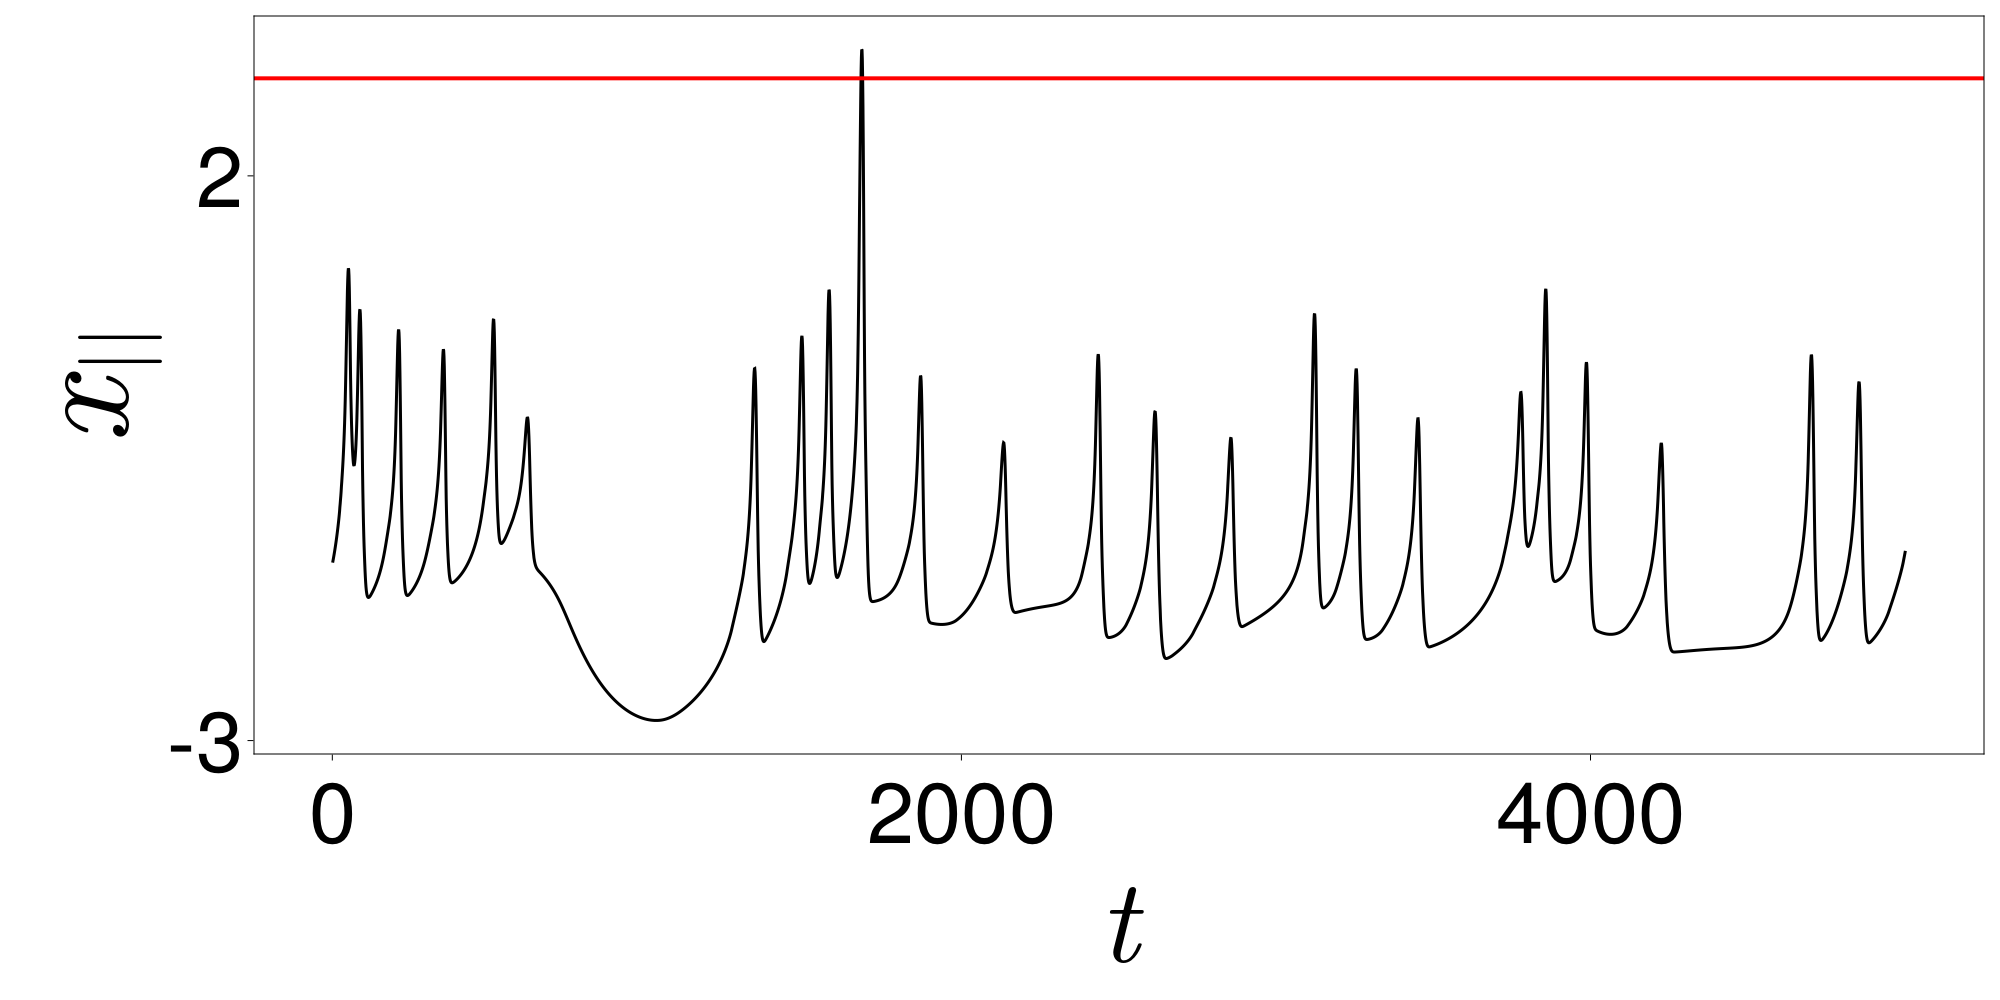

In [19]:
f = Figure(resolution = (2000, 1000))

ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x_{||}",
xlabelsize = 120, ylabelsize = 140,
                xticklabelsize = 85, yticklabelsize = 85, yticks = [-3, 2])
ax.xgridvisible = false
ax.ygridvisible = false
lines!(ax, xsum[50000:55000], linewidth = 3.0, color = "black")
# hlines!(Hs2, color = "red", linewidth = 1.0, linestyle = :dash)
hlines!(Hs1, color = "red", linewidth = 4.0)


save("timesrieshyperchaos.eps", f)
f

In [112]:
sel_1, pdf_1 = CALCPDF(xsum)

(0.0:8.000016000032e-6:4.0, [0.03943901525256738, 0.03943882263316502, 0.039438437394360294, 0.0394374742973485, 0.0394365112003367, 0.03943631858093434, 0.03943631858093434, 0.03943612596153198, 0.03943516286452018, 0.03943535548392254  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [117]:
save("sel_1_hyperch.jld", "data", sel_1  )
save("pdf_1_hyperch.jld", "data", pdf_1  )

In [53]:
cd("C:\\Users\\Alex\\YandexDisk\\Science\\HR\\PDF")
sel_1 = load("sel_1_hyperch.jld")["data"]
pdf_1 = load("pdf_1_hyperch.jld")["data"];

In [54]:
EE_mapcopy = pdf_1;
EE_mapcopy = [ iszero(x) ? missing : x for x in EE_mapcopy ];

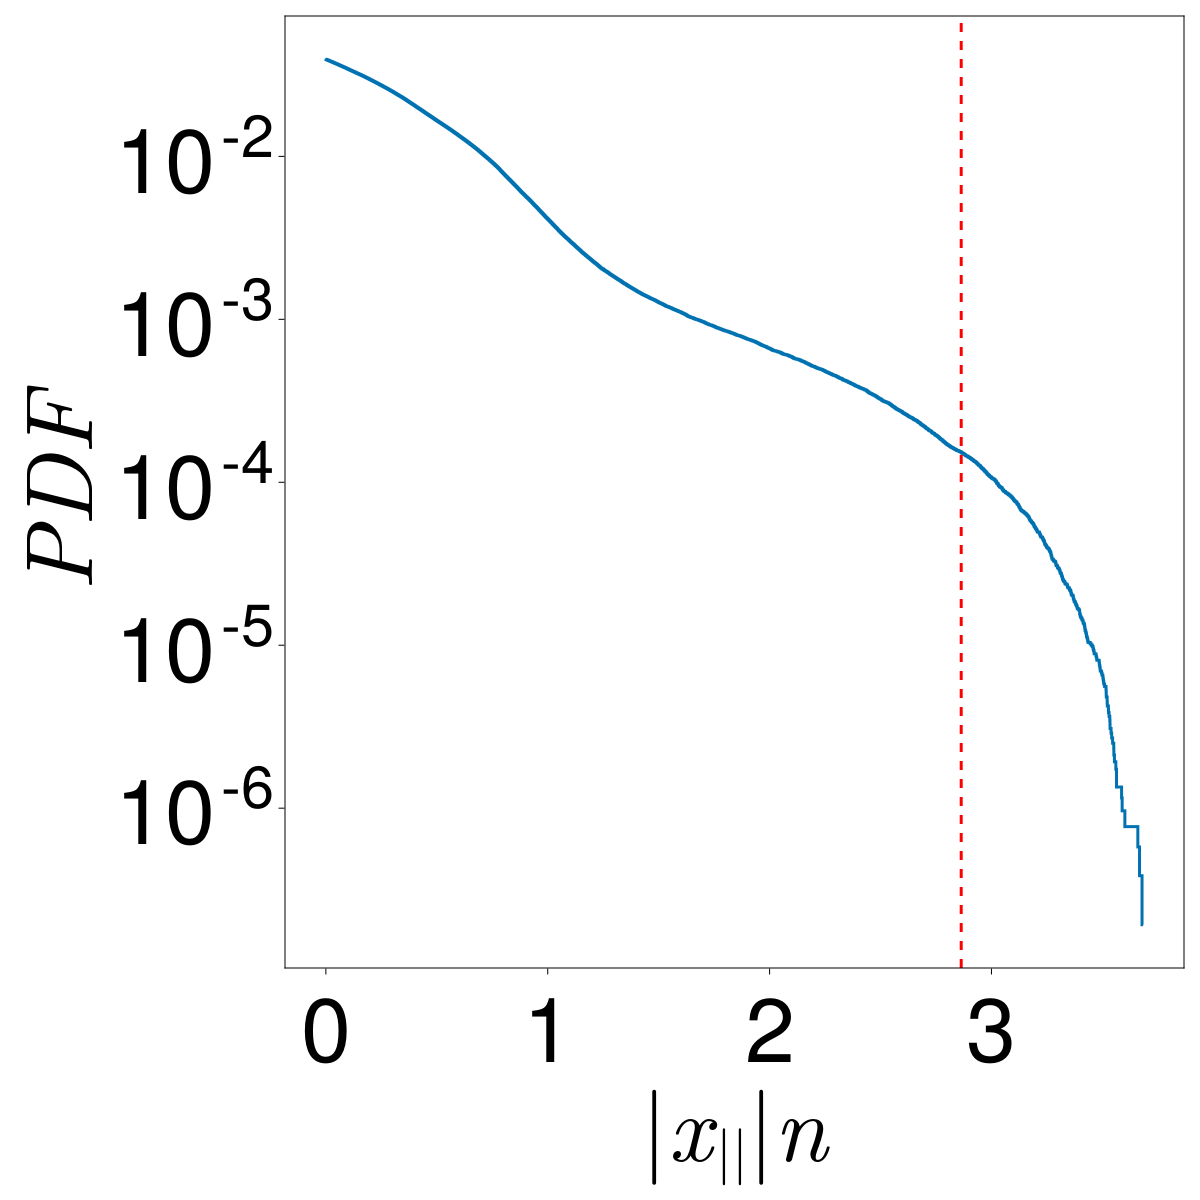

In [55]:
f = Figure(resolution = (1200, 1200))
ax = Axis(f[1, 1], yscale = log10,
xlabel = L"|x_{||}|n", ylabel = L"PDF",
xlabelsize = 95, ylabelsize = 95,
                xticklabelsize = 90, yticklabelsize = 90)
ax.xgridvisible = false
ax.ygridvisible = false

lines!(sel_1, EE_mapcopy, linewidth = 3.0)
vlines!(ax, Hs1, color = "red", linestyle = :dash, linewidth = 3.0)
save("PDF_hyperchaos.eps", f)
f

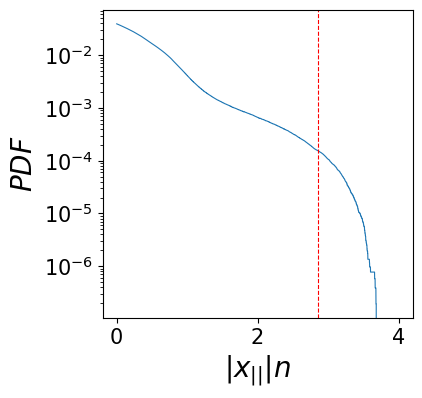

PyObject Text(37.99999999999999, 0.5, '$PDF$')

In [113]:
counts = xsum[xsum.>=Hs1]
counts = length(counts)

fig, ax = subplots(figsize = (4, 4))

ax.set_yscale("log")

ax.plot(sel_1, pdf_1, label  = "k: $k", lw  = 0.8)
ax.axvline(Hs1, color ="red", linestyle ="--", lw = 0.8, label = "count: $counts")
ax.tick_params(labelsize = 15)
ax.set_xlabel(L"|x_{||}|n", fontsize = 20)
ax.set_ylabel(L"PDF", fontsize = 20)
# ax.legend(loc="upper left", fontsize = 25)

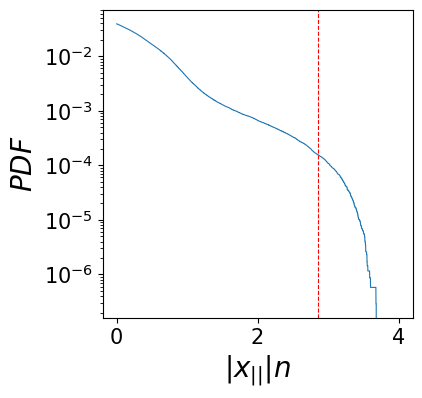

PyObject Text(37.99999999999999, 0.5, '$PDF$')

In [148]:
counts = xsum[xsum.>=Hs1]
counts = length(counts)

fig, ax = subplots(figsize = (4, 4))

ax.set_yscale("log")

ax.plot(sel_1, pdf_1, label  = "k: $k", lw  = 0.8)
ax.axvline(Hs1, color ="red", linestyle ="--", lw = 0.8, label = "count: $counts")
ax.tick_params(labelsize = 15)
ax.set_xlabel(L"|x_{||}|n", fontsize = 20)
ax.set_ylabel(L"PDF", fontsize = 20)
# ax.legend(loc="upper left", fontsize = 25)

### border for EE in hyperchaos k = 0.128

## hyperchaos near chaos

### find border

In [10]:
matrix_condition[:, 150]

6-element Vector{Float64}:
  -0.5559157520197522
  -0.9456084422078657
   3.930541279481236
  -1.5030192805499796
 -10.388454091084872
   3.8902303109317913

In [27]:
u0 = SA[ -0.5559157520197522
     -0.9456084422078657
      3.930541279481236
     -1.5030192805499796
     -10.388454091084872
     3.8902303109317913]


p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, 0.149];

In [28]:
ds = ContinuousDynamicalSystem(HR, u0, p)

6-dimensional continuous dynamical system
 state:       [-0.555916, -0.945608, 3.93054, -1.50302, -10.3885, 3.89023]
 rule f:      HR
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, …, 2.0, -0.17, -0.17, 0.149]

In [70]:
k_space = range( 0.155, 0.1556, step = 0.00004)
spectrum_ma = zeros( length(k_space), 6 )

16×6 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

In [71]:
for (i, k) in enumerate(k_space)
    
    if i == 1
        global cond = SA[-0.78629064675929, -1.9425178135636958, 4.337726074464146, -1.315684700752532, -7.804809138062392, 3.732179750672859]
        init = 1
    else
        init = 0
    end
    
    println("index: $i"); flush(stdout)
    println("k: $k"); flush(stdout)
    println("u0: $cond")
    
    if init == 1
        println("initalization ds, lyapunovspectrum"); flush(stdout)
    end
    p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k];
    ds = ContinuousDynamicalSystem(HR, cond, p)
    
    spectrum = lyapunovspectrum(ds, 300000.0; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))
    if init == 1
        println("initalization ODEProblem, solve"); flush(stdout)
    end
    prob = ODEProblem(HR, cond, 300000.0, p)
    sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000);
    cond = sol[end]
    
    println("spectrum: $spectrum"); flush(stdout)
    spectrum_ma[i, :] = spectrum
    println("last points: $cond")
    println(">>>>>>>>>>>>>>>>>>");flush(stdout)
    println("")
    
end

index: 1
k: 0.155
u0: [-0.78629064675929, -1.9425178135636958, 4.337726074464146, -1.315684700752532, -7.804809138062392, 3.732179750672859]
initalization ds, lyapunovspectrum
initalization ODEProblem, solve
spectrum: [0.01568472291973407, 0.00293124888387621, 4.329657005262885e-7, -0.0073456144327267775, -5.784390296774169, -11.89614069588815]
last points: [-1.3772196935844374, -7.900281782074273, 4.121703324901386, 0.04605115902141608, 0.6480123049951765, 4.025556404628821]
>>>>>>>>>>>>>>>>>>

index: 2
k: 0.15504
u0: [-1.3772196935844374, -7.900281782074273, 4.121703324901386, 0.04605115902141608, 0.6480123049951765, 4.025556404628821]
spectrum: [0.015836066952597136, 0.0030073807566713155, -1.5086450965572597e-6, -0.006980421832606299, -5.8178526896169185, -11.856921105184352]
last points: [-1.2981493305560035, -7.770290662815524, 3.5118976993067883, -0.8617001741417685, -2.38361139019767, 4.457934077502285]
>>>>>>>>>>>>>>>>>>

index: 3
k: 0.15508
u0: [-1.2981493305560035, -7.770290

### k[0.155, 0.1556]; step = 0.00004

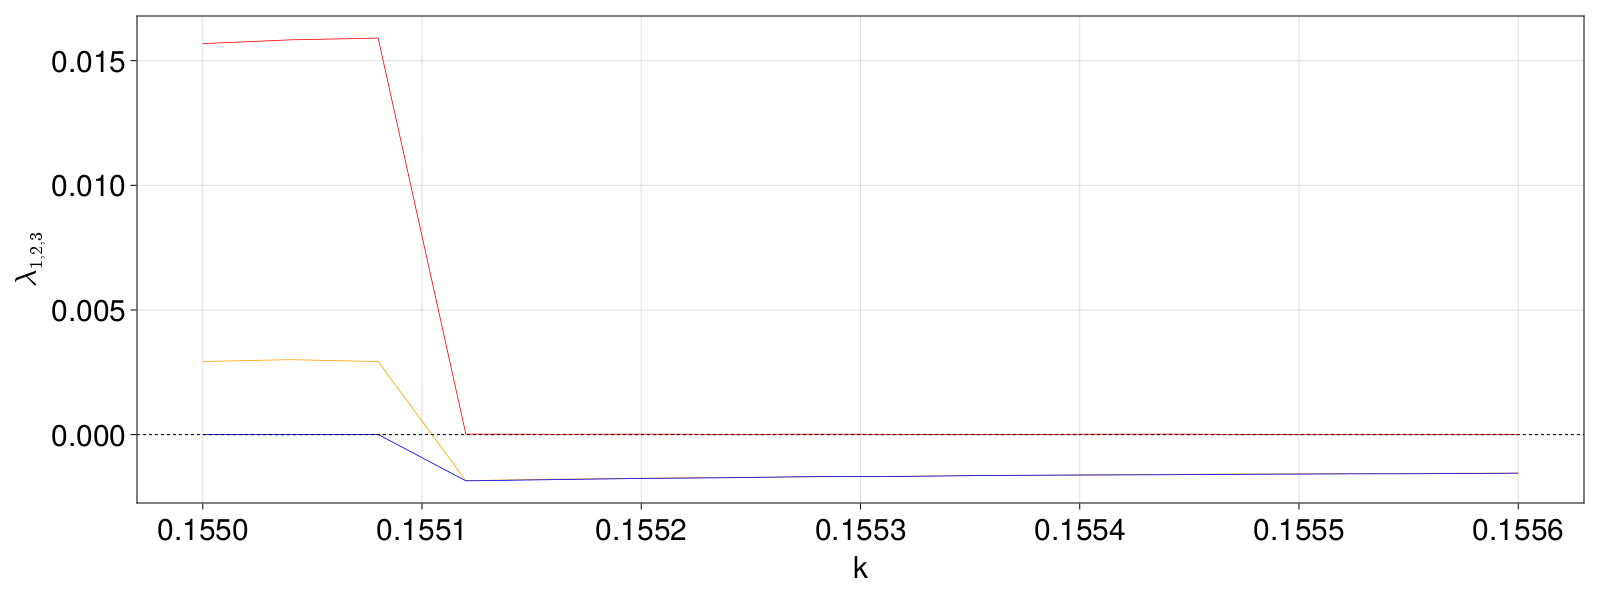

In [72]:
f = Figure(resolution = (1600, 600), fontsize = 30)
ax = Axis(f[1, 1], xlabel = "k", ylabel = L"\lambda_{1, 2, 3}")
le1 = lines!(ax, k_space, spectrum_ma[:, 1], color = "red", linewidth = 0.8)
le2 = lines!(ax, k_space, spectrum_ma[:, 2], color = "orange", linewidth = 0.8)
le3 = lines!(ax, k_space, spectrum_ma[:, 3], color = "blue", linewidth = 0.8)
zeroline = hlines!(ax, 0.0, color = "black", linestyle = :dash, linewidth = 1.0 )
f

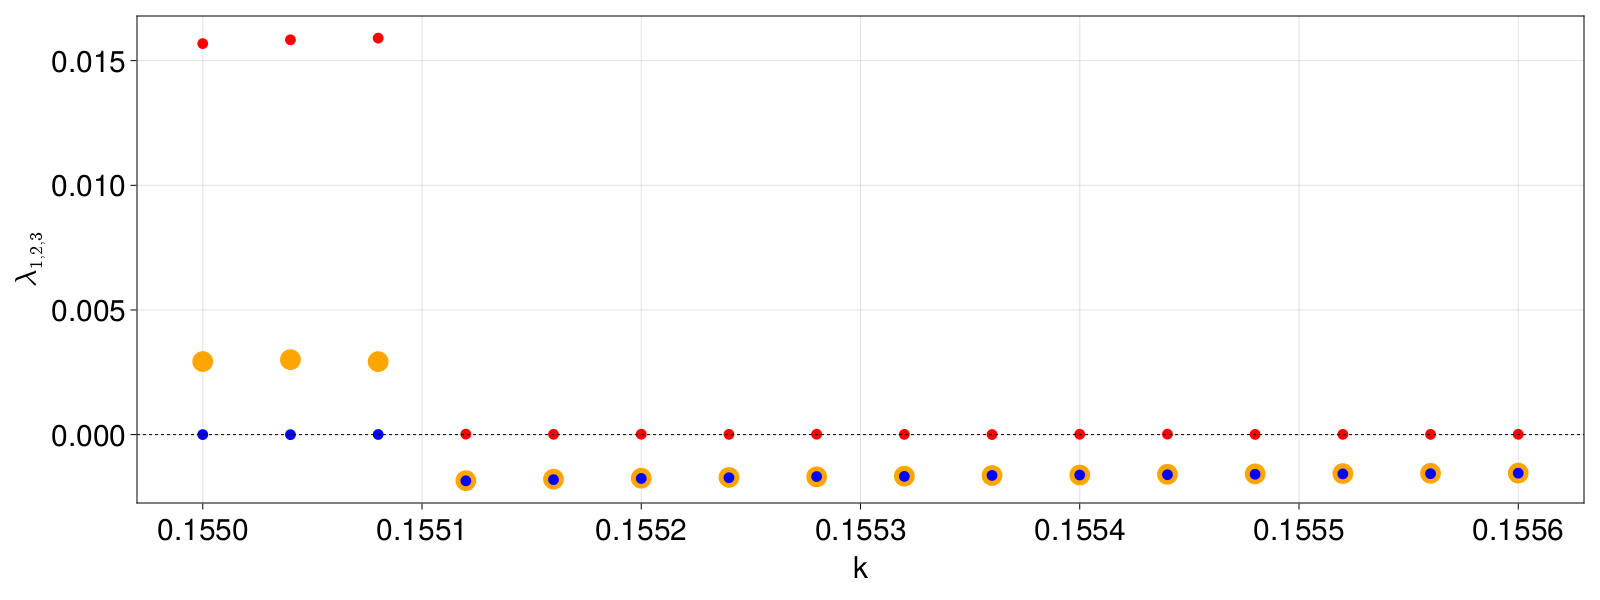

In [73]:
f = Figure(resolution = (1600, 600), fontsize = 30)
ax = Axis(f[1, 1], xlabel = "k", ylabel = L"\lambda_{1, 2, 3}")
le1 = scatter!(ax, k_space[:], spectrum_ma[:, 1], color = "red", markersize = 10.8)
le2 = scatter!(ax, k_space[:], spectrum_ma[:, 2], color = "orange", markersize = 20.8)
le3 = scatter!(ax, k_space[:], spectrum_ma[:, 3], color = "blue", markersize = 10.8)
zeroline = hlines!(ax, 0.0, color = "black", linestyle = :dash, linewidth = 1.0 )
f

### k [0.155, 160]; step = 0.0002

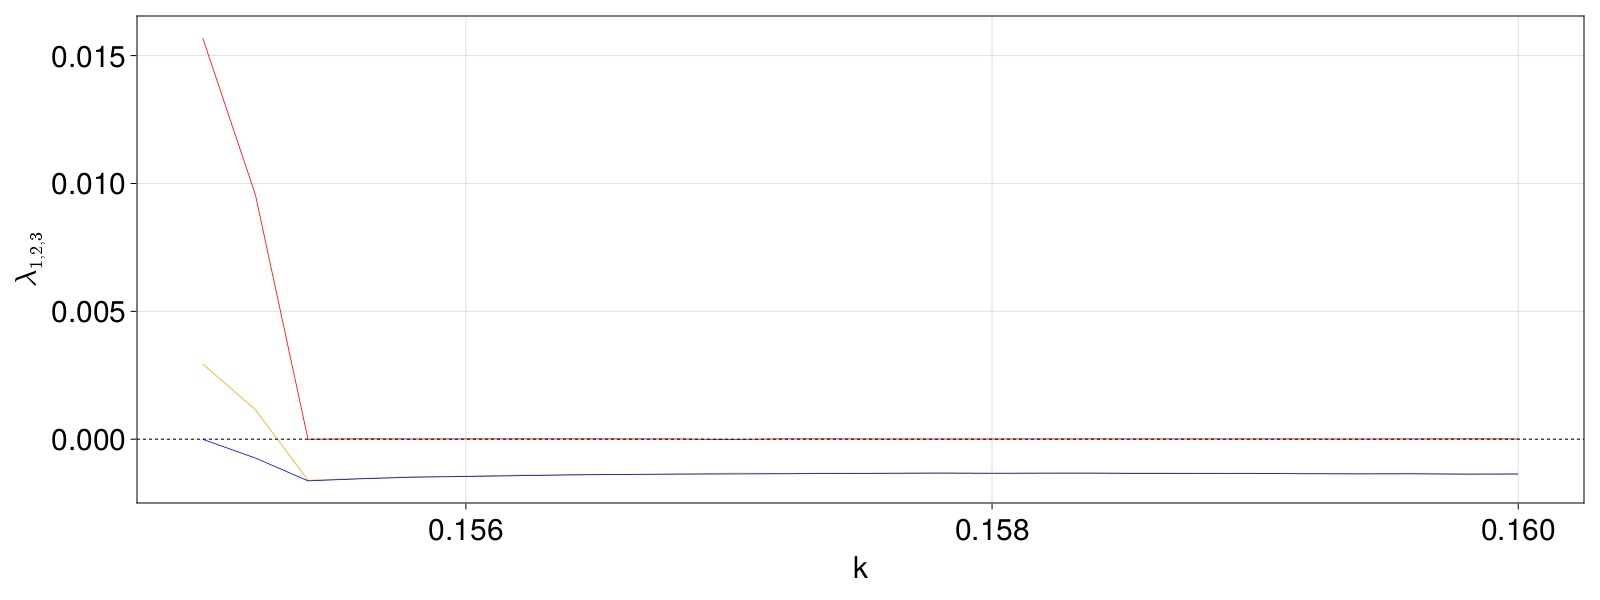

In [56]:
f = Figure(resolution = (1600, 600), fontsize = 30)
ax = Axis(f[1, 1], xlabel = "k", ylabel = L"\lambda_{1, 2, 3}")
le1 = lines!(ax, k_space, spectrum_ma[:, 1], color = "red", linewidth = 0.8)
le2 = lines!(ax, k_space, spectrum_ma[:, 2], color = "orange", linewidth = 0.8)
le3 = lines!(ax, k_space, spectrum_ma[:, 3], color = "blue", linewidth = 0.8)
zeroline = hlines!(ax, 0.0, color = "black", linestyle = :dash, linewidth = 1.0 )
f

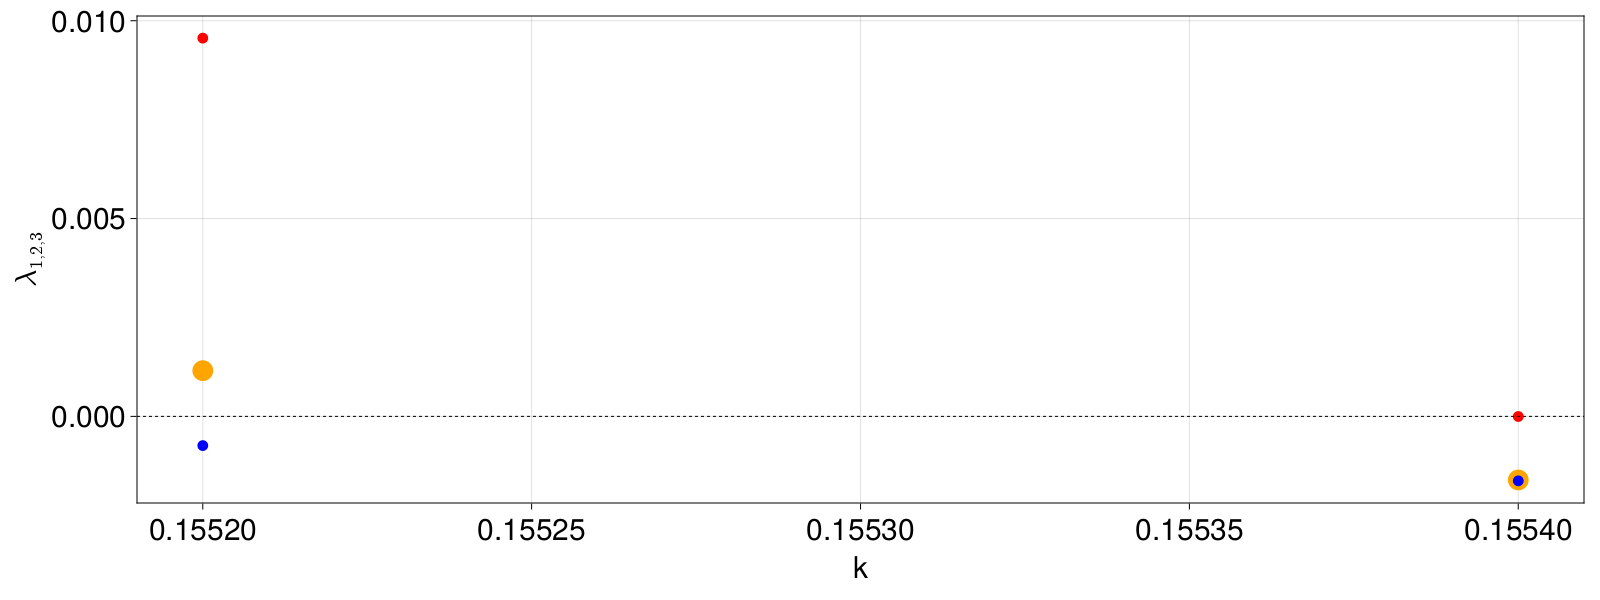

In [61]:
f = Figure(resolution = (1600, 600), fontsize = 30)
ax = Axis(f[1, 1], xlabel = "k", ylabel = L"\lambda_{1, 2, 3}")
le1 = scatter!(ax, k_space[2:3], spectrum_ma[2:3, 1], color = "red", markersize = 10.8)
le2 = scatter!(ax, k_space[2:3], spectrum_ma[2:3, 2], color = "orange", markersize = 20.8)
le3 = scatter!(ax, k_space[2:3], spectrum_ma[2:3, 3], color = "blue", markersize = 10.8)
zeroline = hlines!(ax, 0.0, color = "black", linestyle = :dash, linewidth = 1.0 )
f

### k [0.150, 160]; step = 0.0005

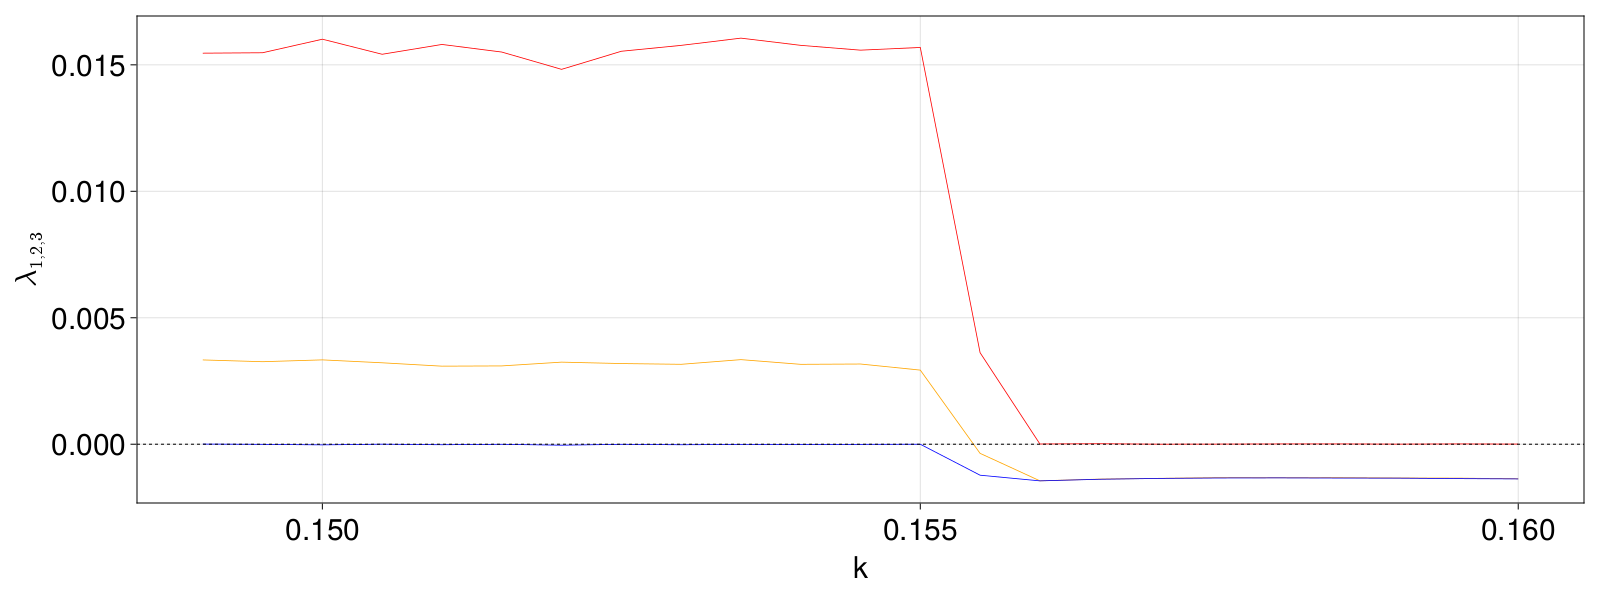

In [49]:
f = Figure(resolution = (1600, 600), fontsize = 30)
ax = Axis(f[1, 1], xlabel = "k", ylabel = L"\lambda_{1, 2, 3}")
le1 = lines!(ax, k_space, spectrum_ma[:, 1], color = "red", linewidth = 0.8)
le2 = lines!(ax, k_space, spectrum_ma[:, 2], color = "orange", linewidth = 0.8)
le3 = lines!(ax, k_space, spectrum_ma[:, 3], color = "blue", linewidth = 0.8)
zeroline = hlines!(ax, 0.0, color = "black", linestyle = :dash, linewidth = 1.0 )
f

### near border value for hyperchaos is k = 0.155

### plot pdf

In [9]:
u0 = SA[-0.78629064675929, -1.9425178135636958, 4.337726074464146,
        -1.315684700752532, -7.804809138062392, 3.732179750672859]
k = 0.155
p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k];

prob = ODEProblem(HR, u0, 300000.0, p)
sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000);

In [10]:
xsum = sol[1, :] + sol[4, :];
println("before: ", length(xsum))

xsum = xsum[floor(Int, length(xsum) / 4):end ]
println("after: ", length(xsum))

before: 4154074
after: 3115557


In [11]:
spikes = peaks(xsum);
Hs1 = Hs(spikes, 6)

4.235834082708717

In [12]:
index = signal.argrelmax( xsum )[1]
spikes2 = [xsum[x] for x in index]
Hs2 = Statistics.mean(spikes2) + 6 * Statistics.std(spikes2)

4.192813519220736

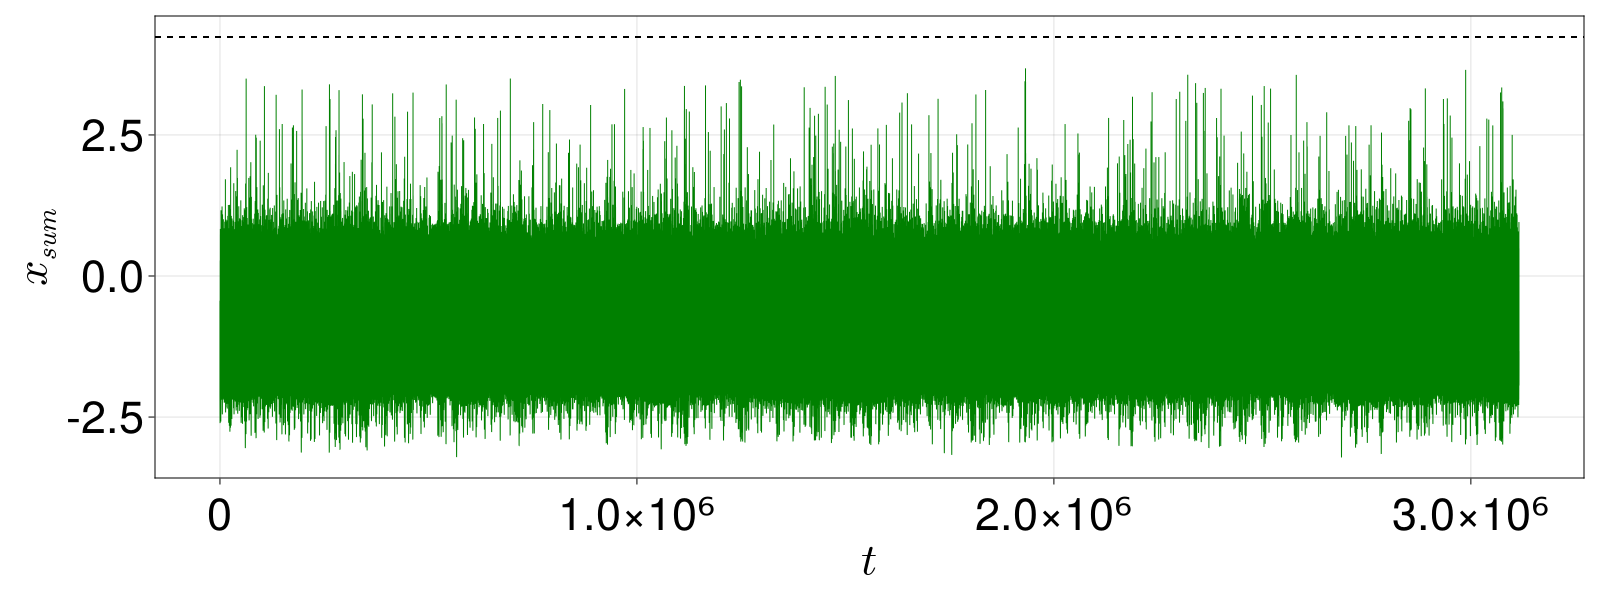

In [13]:
f = Figure(resolution = (1600, 600), fontsize = 45)
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x_{sum}")
line = lines!(ax, xsum, linewidth = 1.0, color = "green")
threshold1 = hlines!(Hs1, linewidth = 2.0, color = "black", linestyle = :dash)
f

In [14]:
using PyPlot

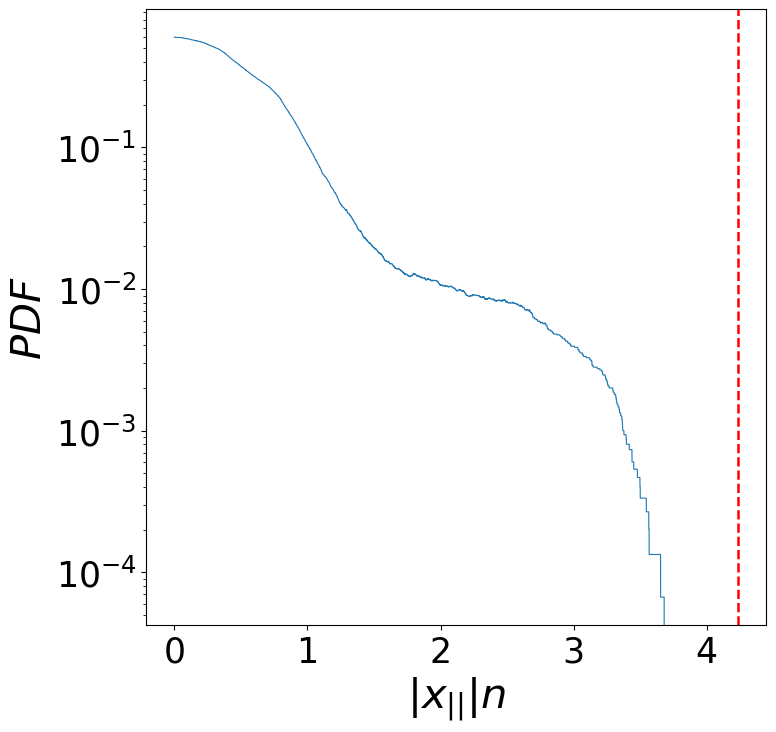

PyObject Text(50.0, 0.5, '$PDF$')

In [15]:
sel_1, pdf_1 = CALCPDF(spikes)

counts = spikes[spikes.>=Hs1]
counts = length(counts)

fig, ax = subplots(figsize = (8, 8))

ax.set_yscale("log")

ax.plot(sel_1, pdf_1, label  = "k: $k", lw  = 0.8)
ax.axvline(Hs1, color ="red", linestyle ="--", lw = 1.8, label = "count: $counts")
ax.tick_params(labelsize = 25)

ax.set_xlabel(L"|x_{||}|n", fontsize = 30)
ax.set_ylabel(L"PDF", fontsize = 30)

#ax.legend(loc="upper left", fontsize = 25)

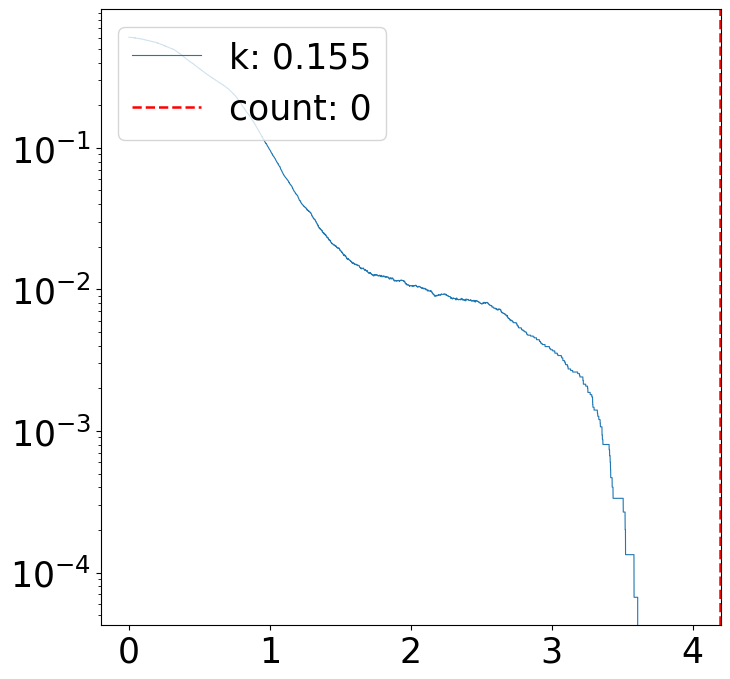

PyObject <matplotlib.legend.Legend object at 0x00000000BD974070>

In [16]:
sel_2, pdf_2 = CALCPDF(spikes2)

counts2 = spikes2[spikes2.>=Hs2]
counts2 = length(counts2)

fig, ax = subplots(figsize = (8, 8))

ax.set_yscale("log")

ax.plot(sel_2, pdf_2, label  = "k: $k", lw  = 0.8)
ax.axvline(Hs2, color ="red", linestyle ="--", lw = 1.8, label = "count: $counts")
ax.tick_params(labelsize = 25)
ax.legend(loc="upper left", fontsize = 25)

In [17]:
p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k];
ds = ContinuousDynamicalSystem(HR, u0, p)

6-dimensional continuous dynamical system
 state:       [-0.786291, -1.94252, 4.33773, -1.31568, -7.80481, 3.73218]
 rule f:      HR
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, …, 2.0, -0.17, -0.17, 0.155]

In [18]:
spectrum = lyapunovspectrum(ds, 300000.0; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))

6-element Vector{Float64}:
   0.015683407516955242
   0.002936089225071499
  -1.013783816575987e-5
  -0.007333529399567912
  -5.7844034366371915
 -11.896132595190117

### strange attractor

In [19]:
u0 = SA[0.01, 0.01, 0.01,
        0.01, 0.01, 0.01]

k = 0.155
p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k];

prob = ODEProblem(HR, u0, 300000.0, p)
sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000);

In [20]:
xsum = sol[1, :] + sol[4, :];
println("before: ", length(xsum))

xsum = xsum[floor(Int, length(xsum) / 4):end ]
println("after: ", length(xsum))

before: 3335371
after: 2501530


In [21]:
spikes = peaks(xsum);
Hs1 = Hs(spikes, 6)

4.953922946318968

In [22]:
index = signal.argrelmax( xsum )[1]
spikes2 = [xsum[x] for x in index]
Hs2 = Statistics.mean(spikes2) + 6 * Statistics.std(spikes2)

4.851880972625149

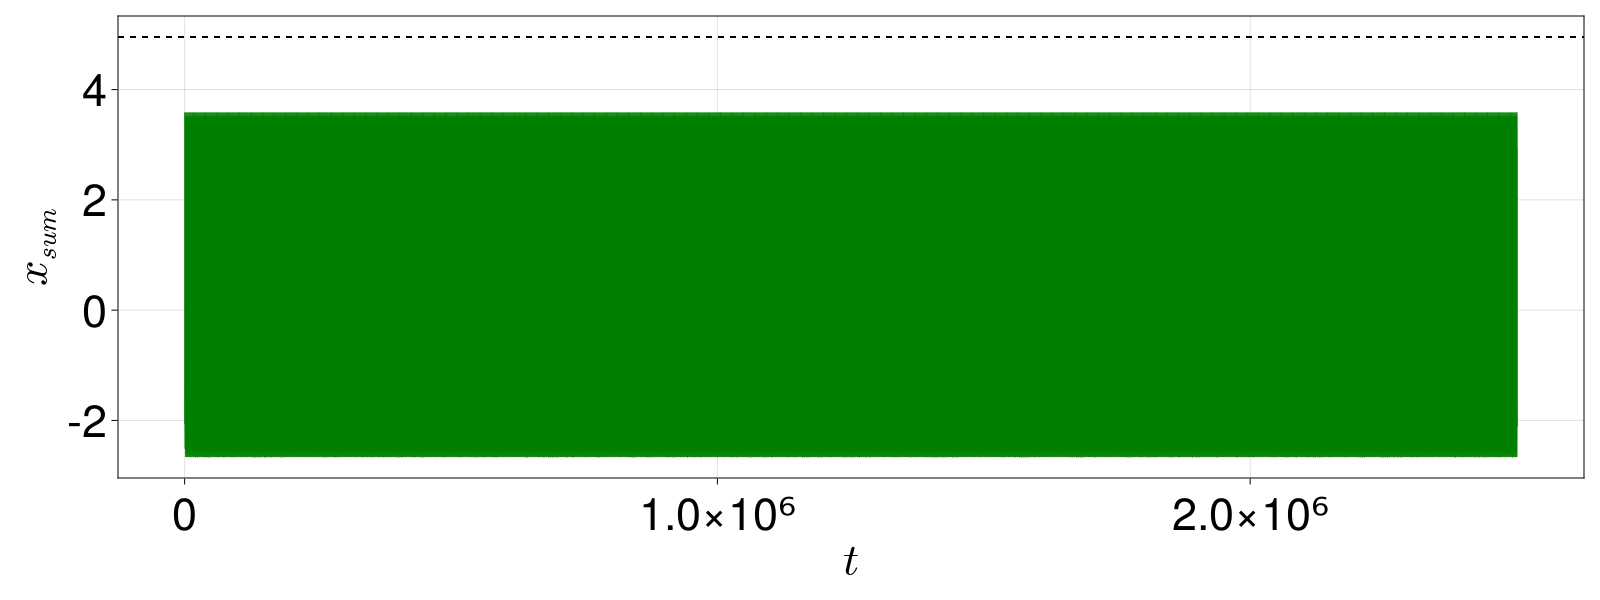

In [23]:
f = Figure(resolution = (1600, 600), fontsize = 45)
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x_{sum}")
line = lines!(ax, xsum, linewidth = 1.0, color = "green")
threshold1 = hlines!(Hs1, linewidth = 2.0, color = "black", linestyle = :dash)
f

In [24]:
using PyPlot

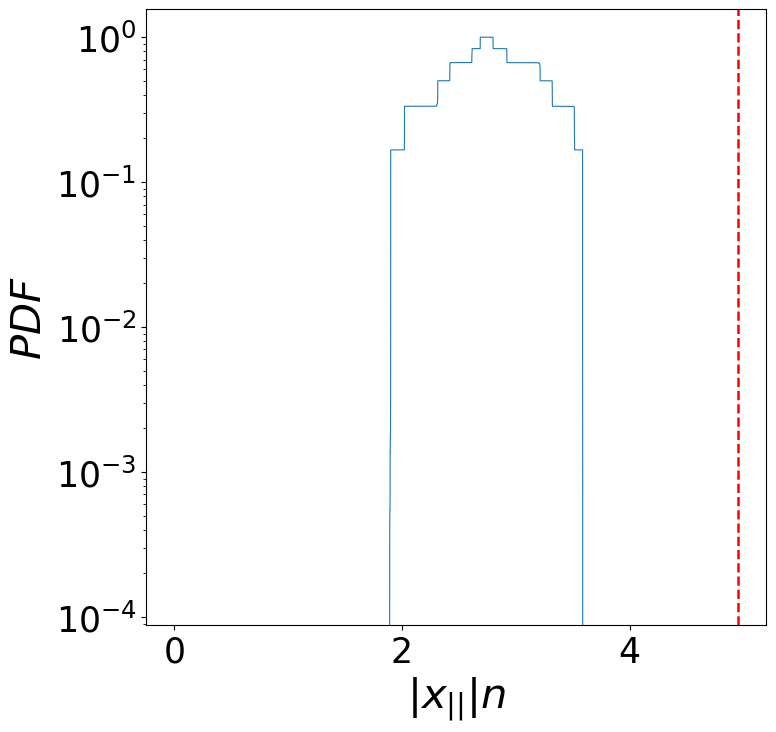

PyObject Text(50.0, 0.5, '$PDF$')

In [25]:
sel_1, pdf_1 = CALCPDF(spikes)

counts = spikes[spikes.>=Hs1]
counts = length(counts)

fig, ax = subplots(figsize = (8, 8))

ax.set_yscale("log")

ax.plot(sel_1, pdf_1, label  = "k: $k", lw  = 0.8)
ax.axvline(Hs1, color ="red", linestyle ="--", lw = 1.8, label = "count: $counts")
ax.tick_params(labelsize = 25)

ax.set_xlabel(L"|x_{||}|n", fontsize = 30)
ax.set_ylabel(L"PDF", fontsize = 30)

#ax.legend(loc="upper left", fontsize = 25)

In [26]:
p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k];
ds = ContinuousDynamicalSystem(HR, u0, p)

6-dimensional continuous dynamical system
 state:       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
 rule f:      HR
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, …, 2.0, -0.17, -0.17, 0.155]

In [27]:
spectrum = lyapunovspectrum(ds, 300000.0; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))

6-element Vector{Float64}:
  0.06786878160006041
  0.008209032791559304
  4.5920493946937315e-5
 -0.004373409433071168
 -8.826967978201957
 -9.07525716122919